In [1]:
# Imports
# Import standard packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import corner
import pocomc as pc
import os

ModuleNotFoundError: No module named 'torch'

In [2]:
# Define functions
def delta_function(c, m):
    """
    Compute delta, the decay constant
    """
    return c/2/m

def omega0_function(k, m):
    """
    Compute omega_0, the oscillation frequency for the undamped oscillator
    """
    return k/m
    
def underdamped_pos(t, m, A, phi, c, k):
    """
    Compute the underdamped position at the time array t, throws an error
    if the input produces a critically damped or overdamped oscillator
    """
    delta = delta_function(c, m)
    omega0 = omega0_function(k, m)
    if delta >= omega0:
        raise ValueError('System is not underdamped. Damper is too strong.')
    omega = np.sqrt(omega0**2 - delta**2)
    return np.exp(-delta*t)*A*np.cos(omega*t+phi)

def underdamped_envelope(t, m, A, c):
    """
    Compute the underdamped positive envelope at the time array t
    """
    delta = delta_function(c, m)
    return A*np.exp(-delta*t)

In [3]:
# Injection 

# set time and mass, the fixed known quantities
t = np.linspace(0, 19, 20) # time array for data
t_fine = np.linspace(0, 19, 1000) # fine time array for plot
m = 3

# set allowed ranges for other parameters
# param order = A, phi, c, k
min_params = np.array([1, 0, 0.5, 1])
max_params = np.array([5, 2*np.pi, 2, 5])
bounds = np.array([(min_params[i], max_params[i]) for i in range(4)])
# to make it underdamped, half of the max c should be less than the min k 
# (equal is fine because the max is never achieved)

# generate the true parameters, comment out the first line and uncomment the second in order
# to use the parameters used in the talk
# true_params = np.random.uniform(low=min_params, high=max_params)
true_params = np.array([3.87150364, 4.08570741, 1.09783054, 3.10030603]) # explicitly use the parameters from the talk
true_A, true_phi, true_c, true_k = true_params # unpack array of injected parameters

# create signal from the (true) injected parameters
signal = underdamped_pos(t, m, true_A, true_phi, true_c, true_k)
signal_fine = underdamped_pos(t_fine, m, true_A, true_phi, true_c, true_k)
pos_env_fine = underdamped_envelope(t_fine, m, true_A, true_c)
neg_env_fine = -underdamped_envelope(t_fine, m, true_A, true_c)

# add gaussian noise to signal to simulate error
errors = np.full(20, 0.1)
noise = np.random.normal(loc=0.0, scale=errors)
data = signal + noise


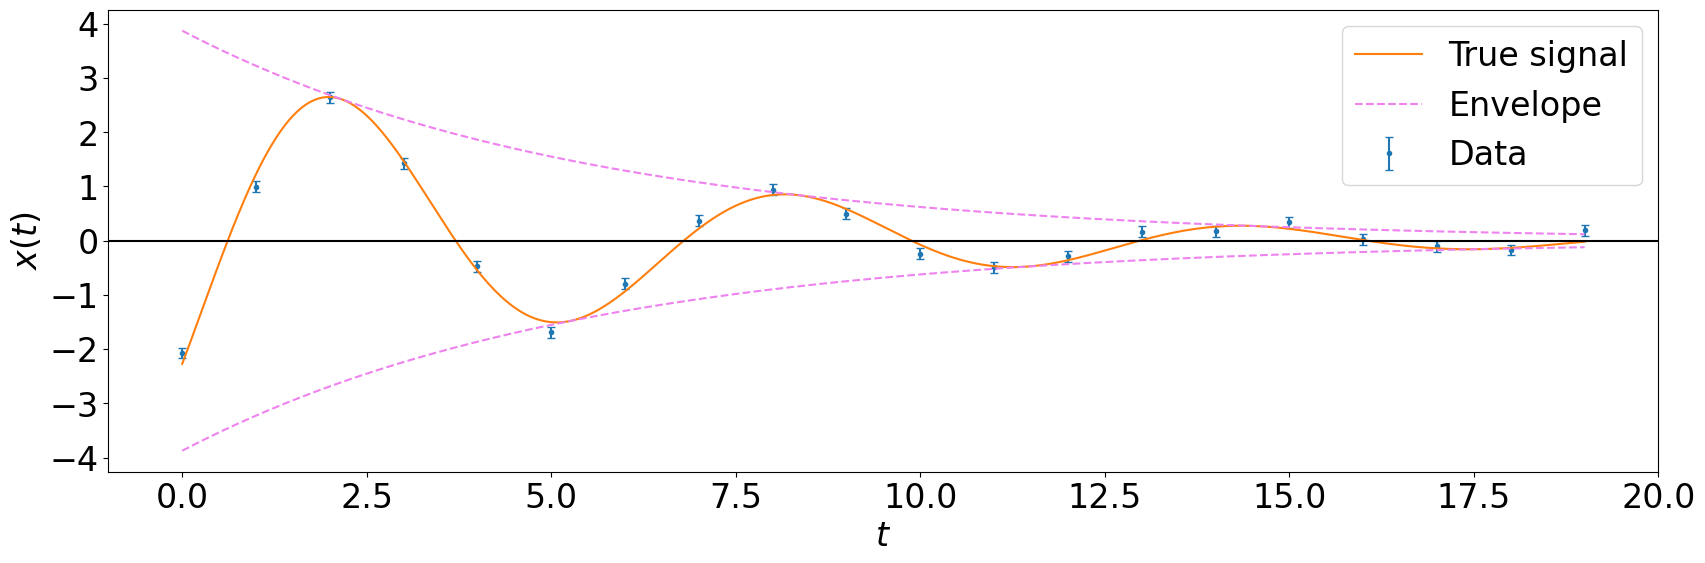

In [4]:
# Plot the data and the true signal
%matplotlib inline

fontsize=24

plt.figure(figsize = (20,6))
plt.errorbar(t, data, yerr=errors, barsabove=True, capsize=3.0, fmt='.', label = 'Data')
plt.plot(t_fine, signal_fine, label = 'True signal')
plt.plot(t_fine, pos_env_fine, label = 'Envelope', color='violet', linestyle='dashed')
plt.plot(t_fine, neg_env_fine, color='violet', linestyle='dashed')
plt.plot(np.linspace(-1, 20, 22), np.zeros(22), color='k')
plt.xlabel(r'$t$', fontsize = fontsize)
plt.ylabel(r'$x(t)$', fontsize = fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim(-1, 20)
plt.legend(prop={'size': fontsize})
plt.show()

In [5]:
# define the natural logarithm of the likelihood
def loglike(params, t, m, data, error):
    """
    Compute the log likelihood function
    """
    model = underdamped_pos(t, m, *params)
    return -1/2*np.sum(((data-model)/error)**2)

ndim = 4

class CustomPrior:
    def __init__(self):
        self.dim = ndim
        self.bounds = bounds

    def logpdf(self, params):
        return np.zeros(params.shape[0])

    def rvs(self, size=1):
        output_transpose = np.empty([ndim, size])
        for i in range(ndim):
            output_transpose[i] = np.random.uniform(low=bounds[i,0], high=bounds[i,1], size=size)
        return output_transpose.T

prior = CustomPrior()

In [6]:
# # run this to get an estimate of the runtime of one likelihood evaluation
# %timeit loglike(true_params, t, m, data, errors)

In [17]:
# Initialise sampler

if not os.path.exists('runsaves'):
    os.mkdir('runsaves')

if not os.path.exists('runsaves/dampedspringtest'):
    os.mkdir('runsaves/dampedspringtest')

if not os.path.exists('runsaves/dampedspringtest/pocomc_states'):
    os.mkdir('runsaves/dampedspringtest/pocomc_states')

sampler = pc.Sampler(prior=prior,
                    likelihood=loglike,
                    likelihood_args = (t, m, data, errors),
                    periodic=[1],
                    output_dir = 'runsaves/dampedspringtest/pocomc_states')


In [18]:
# Start sampling
sampler.run(save_every = 10)



Iter: 0it [00:00, ?it/s]

Iter: 0it [00:00, ?it/s, beta=0, calls=0, ESS=512, logZ=0, logP=0, acc=0, steps=0, eff=0]

Iter: 0it [00:00, ?it/s, beta=0, calls=256, ESS=512, logZ=0, logP=-1.97e+3, acc=1, steps=1, eff=1]

Iter: 1it [00:00, 115.16it/s, beta=0, calls=512, ESS=512, logZ=0, logP=-1.84e+3, acc=1, steps=1, eff=1]

Iter: 2it [00:00, 153.12it/s, beta=0, calls=768, ESS=512, logZ=0, logP=-1.86e+3, acc=1, steps=1, eff=1]

Iter: 3it [00:00, 170.50it/s, beta=0, calls=1024, ESS=512, logZ=0, logP=-1.87e+3, acc=1, steps=1, eff=1]

Iter: 5it [00:00, 212.29it/s, beta=0.00137, calls=1024, ESS=510, logZ=-1.83, logP=-1.87e+3, acc=1, steps=1, eff=1]

Iter: 5it [00:00,  9.11it/s, beta=0.00137, calls=1280, ESS=510, logZ=-1.83, logP=-985, acc=0.626, steps=1, eff=0.832]

Iter: 5it [00:00,  8.79it/s, beta=0.00137, calls=1536, ESS=510, logZ=-1.83, logP=-1.01e+3, acc=0.607, steps=2, eff=0.832]

Iter: 5it [00:00,  8.48it/s, beta=0.00137, calls=1792, ESS=510, logZ=-1.83, logP=-977, acc=0.617, steps=3, 

Saving PMC state to runsaves/dampedspringtest/pocomc_states/pmc_10.state




Iter: 11it [00:04,  2.08it/s, beta=0.0161, calls=12800, ESS=511, logZ=-6.62, logP=-133, acc=0.76, steps=1, eff=0.832]

Iter: 11it [00:04,  2.08it/s, beta=0.0161, calls=13056, ESS=511, logZ=-6.62, logP=-126, acc=0.751, steps=2, eff=0.832]

Iter: 11it [00:04,  2.08it/s, beta=0.0161, calls=13312, ESS=511, logZ=-6.62, logP=-132, acc=0.73, steps=3, eff=0.832] 

Iter: 11it [00:04,  2.08it/s, beta=0.0161, calls=13568, ESS=511, logZ=-6.62, logP=-129, acc=0.728, steps=4, eff=0.832]

Iter: 11it [00:04,  2.08it/s, beta=0.0161, calls=13824, ESS=511, logZ=-6.62, logP=-129, acc=0.755, steps=5, eff=0.832]

Iter: 12it [00:04,  1.73it/s, beta=0.0161, calls=13824, ESS=511, logZ=-6.62, logP=-129, acc=0.755, steps=5, eff=0.832]

Iter: 12it [00:04,  1.73it/s, beta=0.0238, calls=13824, ESS=507, logZ=-7.47, logP=-129, acc=0.755, steps=5, eff=0.832]

Iter: 12it [00:04,  1.73it/s, beta=0.0238, calls=14080, ESS=507, logZ=-7.47, logP=-97.8, acc=0.722, steps=1, eff=0.832]

Iter: 12it [00:04,  1.73it/s, beta=0.0

Saving PMC state to runsaves/dampedspringtest/pocomc_states/pmc_20.state




Iter: 21it [00:11,  1.23it/s, beta=0.667, calls=25600, ESS=510, logZ=-20.7, logP=-13, acc=0.691, steps=1, eff=0.832]  

Iter: 21it [00:11,  1.23it/s, beta=0.667, calls=25856, ESS=510, logZ=-20.7, logP=-13, acc=0.68, steps=2, eff=0.832] 

Iter: 21it [00:11,  1.23it/s, beta=0.667, calls=26112, ESS=510, logZ=-20.7, logP=-12.9, acc=0.695, steps=3, eff=0.832]

Iter: 21it [00:11,  1.23it/s, beta=0.667, calls=26368, ESS=510, logZ=-20.7, logP=-13, acc=0.668, steps=4, eff=0.832]  

Iter: 21it [00:11,  1.23it/s, beta=0.667, calls=26624, ESS=510, logZ=-20.7, logP=-12.9, acc=0.651, steps=5, eff=0.832]

Iter: 21it [00:11,  1.23it/s, beta=0.667, calls=26880, ESS=510, logZ=-20.7, logP=-13.1, acc=0.662, steps=6, eff=0.832]

Iter: 22it [00:11,  1.19it/s, beta=0.667, calls=26880, ESS=510, logZ=-20.7, logP=-13.1, acc=0.662, steps=6, eff=0.832]

Iter: 22it [00:11,  1.19it/s, beta=0.958, calls=26880, ESS=511, logZ=-24.3, logP=-13.1, acc=0.662, steps=6, eff=0.832]

Iter: 22it [00:12,  1.19it/s, beta=0.958

Saving PMC state to runsaves/dampedspringtest/pocomc_states/pmc_30.state




Iter: 31it [00:26,  1.74s/it, beta=1, calls=39680, ESS=3009, logZ=-24.8, logP=-12.1, acc=0.788, steps=1, eff=0.832]

Iter: 31it [00:26,  1.74s/it, beta=1, calls=39936, ESS=3009, logZ=-24.8, logP=-12.1, acc=0.782, steps=2, eff=0.832]

Iter: 31it [00:26,  1.74s/it, beta=1, calls=40192, ESS=3009, logZ=-24.8, logP=-12, acc=0.787, steps=3, eff=0.832]  

Iter: 31it [00:26,  1.74s/it, beta=1, calls=40448, ESS=3009, logZ=-24.8, logP=-11.9, acc=0.802, steps=4, eff=0.832]

Iter: 31it [00:26,  1.74s/it, beta=1, calls=40704, ESS=3009, logZ=-24.8, logP=-12, acc=0.778, steps=5, eff=0.832]  

Iter: 31it [00:26,  1.74s/it, beta=1, calls=40960, ESS=3009, logZ=-24.8, logP=-12.1, acc=0.774, steps=6, eff=0.832]

Iter: 31it [00:26,  1.74s/it, beta=1, calls=41216, ESS=3009, logZ=-24.8, logP=-12.1, acc=0.773, steps=7, eff=0.832]

Iter: 32it [00:26,  1.90s/it, beta=1, calls=41216, ESS=3009, logZ=-24.8, logP=-12.1, acc=0.773, steps=7, eff=0.832]

Iter: 32it [00:26,  1.90s/it, beta=1, calls=41216, ESS=3271, l

Saving PMC state to runsaves/dampedspringtest/pocomc_states/pmc_final.state


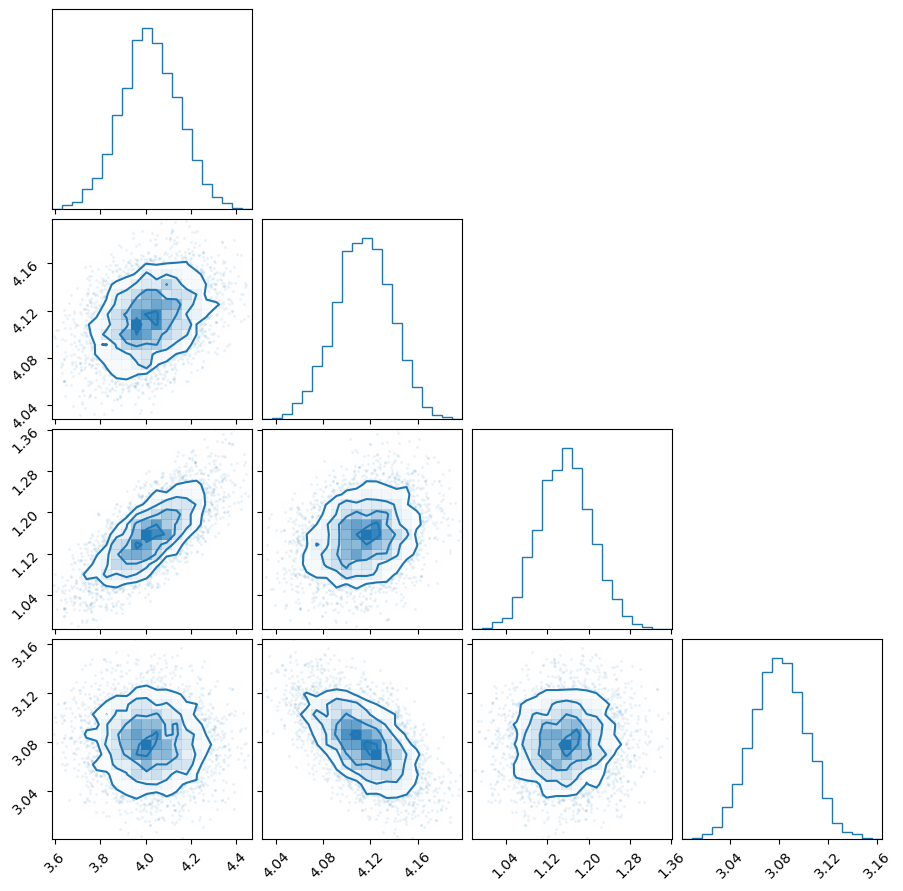

In [10]:
import matplotlib.pyplot as plt
import corner

# Get the results
samples, weights, logl, logp = sampler.posterior()

# Trace plot for the first 4 parameters
fig = corner.corner(samples[:,:4], weights=weights, color="C0")
plt.show()

In [ ]:
# Start sampling
sampler.run(save_every = 10)